### Final Project - Traverse City : Precipitation

Team Members:<br>
    Tarush Singh <br>
    Hitesh Pant<br>
    Shruti Tambe<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from keras.models import Sequential, Model

from keras.optimizers import Adam
from keras import mixed_precision
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization, ConvLSTM2D, Attention, GlobalAveragePooling2D, Layer


/home/tarush/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2023-12-13 14:00:13.586486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 14:00:13.586517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 14:00:13.587206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already bee

From the data we have dropped data for the night-time  valid data for the experiment and can be used to extract important insights from its surrounding areas.
Performed EDA and handled mossing values:

m or M: Data is missing
NC: Wind Chill/Heat Index do not meet the required thresholds to be calculated


In [2]:
df = pd.read_csv('filtered_les_new.csv')

In [3]:
df.head()

,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,LES_Precipitation
0,goes11.2006.10.01.1400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1400.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.07, 0.0625, 0.06, 0.0725, 0.06...","[array([ nan, nan, nan, ...",60.0,49.0,10,270,3600,0,0,10,994.7,1017.8,1017.6,0.0,0.0
1,goes11.2006.10.01.1500.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1500.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.067499995, 0.06, 0.06, 0.05749...","[array([ nan, nan, nan, ...",60.0,47.0,3,0,0,0,0,10,994.7,1017.7,1017.6,0.0,0.0
2,goes11.2006.10.01.1600.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1600.v01.nc-var1-t0.csv.csv,"[0.0725, 0.067499995, 0.07, 0.07, 0.067499995,...","[array([ nan, nan, nan, nan, nan...",59.0,55.0,6,40,0,0,0,10,994.7,1017.8,1017.6,0.0,0.0
3,goes11.2006.10.01.1700.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1700.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.067499995, 0.067499995, 0.07, ...","[array([ nan, nan, nan, nan, nan, nan, n...",55.0,71.0,0,0,0,0,0,10,994.7,1017.8,1017.6,0.0,0.0
4,goes11.2006.10.01.1800.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1800.v01.nc-var1-t0.csv.csv,"[0.085, 0.085, 0.0875, 0.0725, 0.0775, 0.0775,...","[array([ nan, nan, nan, nan, nan...",50.0,82.0,0,0,8000,0,0,10,994.7,1017.9,1017.6,0.0,0.0


### We write a function to extract datetime from 'File_name_for_1D_lake'

In [4]:


def extract_date_time(filename):
    # Define the patterns using regular expressions
    pattern1 = r'(\d{4}\.\d{2}\.\d{2})\.(\d{4})\.v01\.nc-var1-t0\.csv'
    pattern2 = r'(\d{4}\.\d{2}\.\d{2})\.(\d{4})\.v01\.nc-var0\.csv'

    # Use re.search to find the match in the filename for pattern1
    match1 = re.search(pattern1, filename)
    
    # Use re.search to find the match in the filename for pattern2
    match2 = re.search(pattern2, filename)
    
    if match1:
        # Extract the date and time components from the matched groups
        date_str, time_str = match1.groups()
    elif match2:
        # Extract the date component from the matched groups, set time_str to '0'
        date_str, time_str = match2.groups()
        time_str = '0'
    else:
        return None

    # Extract only the first two characters for the hour component
    hour_str = time_str[:2]

    # Convert the extracted strings to a datetime object
    date_time_obj = datetime.strptime(f'{date_str}.{hour_str}', '%Y.%m.%d.%H')

    # Format the datetime object as required (10/01/2006, 14:00)
    formatted_date = date_time_obj.strftime('%m/%d/%Y')
    formatted_time = date_time_obj.strftime('%H')

    return formatted_date, formatted_time
# Apply the function to create new columns
df[['date', 'time']] = df['File_name_for_1D_lake'].apply(extract_date_time).apply(pd.Series)


In [5]:
df.head()

,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,LES_Precipitation,date,time
0,goes11.2006.10.01.1400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1400.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.07, 0.0625, 0.06, 0.0725, 0.06...","[array([ nan, nan, nan, ...",60.0,49.0,10,270,3600,0,0,10,994.7,1017.8,1017.6,0.0,0.0,10/01/2006,14
1,goes11.2006.10.01.1500.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1500.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.067499995, 0.06, 0.06, 0.05749...","[array([ nan, nan, nan, ...",60.0,47.0,3,0,0,0,0,10,994.7,1017.7,1017.6,0.0,0.0,10/01/2006,15
2,goes11.2006.10.01.1600.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1600.v01.nc-var1-t0.csv.csv,"[0.0725, 0.067499995, 0.07, 0.07, 0.067499995,...","[array([ nan, nan, nan, nan, nan...",59.0,55.0,6,40,0,0,0,10,994.7,1017.8,1017.6,0.0,0.0,10/01/2006,16
3,goes11.2006.10.01.1700.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1700.v01.nc-var1-t0.csv.csv,"[0.067499995, 0.067499995, 0.067499995, 0.07, ...","[array([ nan, nan, nan, nan, nan, nan, n...",55.0,71.0,0,0,0,0,0,10,994.7,1017.8,1017.6,0.0,0.0,10/01/2006,17
4,goes11.2006.10.01.1800.v01.nc-var1-t0.csv,T_goes11.2006.10.01.1800.v01.nc-var1-t0.csv.csv,"[0.085, 0.085, 0.0875, 0.0725, 0.0775, 0.0775,...","[array([ nan, nan, nan, nan, nan...",50.0,82.0,0,0,8000,0,0,10,994.7,1017.9,1017.6,0.0,0.0,10/01/2006,18


Looping through 100 images with progress bar

Extracting and storing the first channel (grayscale)

Reshaping the images [images shape -> (35, 64, 64)]

In [6]:


batch = []
for idx in tqdm(range(100)):
    # im shape -> (64, 64)
    im = cv2.imread(f'lake-michigan-64-2006-2017/lake-michigan-images-64/{int(idx)}.png')
    # Storing 1 channel, since the images are grayscale
    batch.append(im[:,:,0]) 
    # images shape -> (35, 64, 64) 

  0%|          | 0/100 [00:00<?, ?it/s]100%|██████████| 100/100 [00:00<00:00, 3290.01it/s]


In [7]:
len(batch), batch[0].shape

(100, (64, 64))

In [8]:
# pip install imageio

In [9]:
sliding_batch = tf.keras.preprocessing.timeseries_dataset_from_array(batch, None, 6, sequence_stride=1, sampling_rate=1, 
                                                                     batch_size=100)

2023-12-13 14:00:30.001756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 14:00:30.023276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 14:00:30.023541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
for batch in sliding_batch:
    #inputs, targets = batch
    inputs = batch
    print(inputs[0])
    #assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
    # Corresponding target: step 10
    #assert np.array_equal(targets[0], data[10])
    break

tf.Tensor(
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], shape=(6, 64, 64), dtype=uint8)


In [11]:
a = []
for i in range(10):
    a.append(np.arange(i, i + 4).reshape((2, 2)))
a

[array([[0, 1],
        [2, 3]]),
 array([[1, 2],
        [3, 4]]),
 array([[2, 3],
        [4, 5]]),
 array([[3, 4],
        [5, 6]]),
 array([[4, 5],
        [6, 7]]),
 array([[5, 6],
        [7, 8]]),
 array([[6, 7],
        [8, 9]]),
 array([[ 7,  8],
        [ 9, 10]]),
 array([[ 8,  9],
        [10, 11]]),
 array([[ 9, 10],
        [11, 12]])]

### Creating a TensorFlow Dataset for time series analysis

In [12]:
x3 = tf.keras.preprocessing.timeseries_dataset_from_array(a, None, 4, sequence_stride=1, sampling_rate=1)

In [13]:
for batch in x3:
    print(batch)
    print('--')

tf.Tensor(
[[[[ 0  1]
   [ 2  3]]

  [[ 1  2]
   [ 3  4]]

  [[ 2  3]
   [ 4  5]]

  [[ 3  4]
   [ 5  6]]]


 [[[ 1  2]
   [ 3  4]]

  [[ 2  3]
   [ 4  5]]

  [[ 3  4]
   [ 5  6]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 2  3]
   [ 4  5]]

  [[ 3  4]
   [ 5  6]]

  [[ 4  5]
   [ 6  7]]

  [[ 5  6]
   [ 7  8]]]


 [[[ 3  4]
   [ 5  6]]

  [[ 4  5]
   [ 6  7]]

  [[ 5  6]
   [ 7  8]]

  [[ 6  7]
   [ 8  9]]]


 [[[ 4  5]
   [ 6  7]]

  [[ 5  6]
   [ 7  8]]

  [[ 6  7]
   [ 8  9]]

  [[ 7  8]
   [ 9 10]]]


 [[[ 5  6]
   [ 7  8]]

  [[ 6  7]
   [ 8  9]]

  [[ 7  8]
   [ 9 10]]

  [[ 8  9]
   [10 11]]]


 [[[ 6  7]
   [ 8  9]]

  [[ 7  8]
   [ 9 10]]

  [[ 8  9]
   [10 11]]

  [[ 9 10]
   [11 12]]]], shape=(7, 4, 2, 2), dtype=int64)
--


16,000 images, reading each one and extracting the first channel (grayscale data), resulting in a consistent size of (35, 64, 64) for all images.

In [14]:
images = []
for idx in tqdm(range(15959)):
    # im shape -> (64, 64)
    im = cv2.imread('lake-michigan-64-2006-2017/lake-michigan-images-64/' + str(idx) + '.png')
    # Storing 1 channel, since the images are grayscale, and cropping
    images.append(im[8:-8,8:-8,0]) 
    # images shape -> (35, 64, 64) 

100%|██████████| 15959/15959 [00:02<00:00, 5595.82it/s]


In [15]:
imgs_train_batch = tf.keras.preprocessing.timeseries_dataset_from_array(images[:3000], None, 7, sequence_stride=1, 
                                                                        sampling_rate=1, batch_size=3000)
imgs_val_batch = tf.keras.preprocessing.timeseries_dataset_from_array(images[3000:4000], None, 7, sequence_stride=1, 
                                                                       sampling_rate=1, batch_size=1000)

In [16]:
for batch in imgs_train_batch:
    print(batch.shape)
    print('--')

(2994, 7, 48, 48)
--


In [17]:
for batch in imgs_val_batch:
    print(batch.shape)
    print('--')

(994, 7, 48, 48)
--


In [ ]:
#Normalizing the data from 0 to 1

In [18]:
train_dataset = None
for batch in imgs_train_batch:
    train_dataset = np.expand_dims(batch, axis=-1)
    print(train_dataset.shape)
    train_dataset = train_dataset / 255

(2994, 7, 48, 48, 1)


In [19]:
val_dataset = None
for batch in imgs_val_batch:
    val_dataset = np.expand_dims(batch, axis=-1)
    print(val_dataset.shape)
    val_dataset = val_dataset / 255

(994, 7, 48, 48, 1)


create_shifted_frames and then applies it to two datasets, train_dataset and val_dataset
This line extracts another sub-array from the input data, similar to the previous line but starting at the second element and excluding the last element. This essentially creates a one-step shifted version of the original data

In [20]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset) 
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (2994, 6, 48, 48, 1), (2994, 6, 48, 48, 1)
Validation Dataset Shapes: (994, 6, 48, 48, 1), (994, 6, 48, 48, 1)


Displaying frames for example 994.


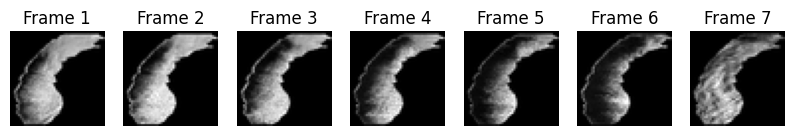

In [21]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 7, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [22]:
x_train.shape

(2994, 6, 48, 48, 1)

In [23]:
x_train.shape[2:]

(48, 48, 1)

In [24]:
(None, x_train.shape[2:])

(None, (48, 48, 1))

In [25]:
(None, *x_train.shape[2:])

(None, 48, 48, 1)

### Data Prep for imagery and meteo

This is how we can going to create our LSTM tensor for meteo data:

In [26]:
a = []
for i in range(50):
    a.append(np.arange(i, i + 4).reshape((2, 2)))
a

[array([[0, 1],
        [2, 3]]),
 array([[1, 2],
        [3, 4]]),
 array([[2, 3],
        [4, 5]]),
 array([[3, 4],
        [5, 6]]),
 array([[4, 5],
        [6, 7]]),
 array([[5, 6],
        [7, 8]]),
 array([[6, 7],
        [8, 9]]),
 array([[ 7,  8],
        [ 9, 10]]),
 array([[ 8,  9],
        [10, 11]]),
 array([[ 9, 10],
        [11, 12]]),
 array([[10, 11],
        [12, 13]]),
 array([[11, 12],
        [13, 14]]),
 array([[12, 13],
        [14, 15]]),
 array([[13, 14],
        [15, 16]]),
 array([[14, 15],
        [16, 17]]),
 array([[15, 16],
        [17, 18]]),
 array([[16, 17],
        [18, 19]]),
 array([[17, 18],
        [19, 20]]),
 array([[18, 19],
        [20, 21]]),
 array([[19, 20],
        [21, 22]]),
 array([[20, 21],
        [22, 23]]),
 array([[21, 22],
        [23, 24]]),
 array([[22, 23],
        [24, 25]]),
 array([[23, 24],
        [25, 26]]),
 array([[24, 25],
        [26, 27]]),
 array([[25, 26],
        [27, 28]]),
 array([[26, 27],
        [28, 29]]),
 a

In [27]:
x3 = tf.keras.preprocessing.timeseries_dataset_from_array(a, None, 24, sequence_stride=24, sampling_rate=1, batch_size=50)

In [28]:
for batch in x3:
    print(batch)
    print('--')

tf.Tensor(
[[[[ 0  1]
   [ 2  3]]

  [[ 1  2]
   [ 3  4]]

  [[ 2  3]
   [ 4  5]]

  [[ 3  4]
   [ 5  6]]

  [[ 4  5]
   [ 6  7]]

  [[ 5  6]
   [ 7  8]]

  [[ 6  7]
   [ 8  9]]

  [[ 7  8]
   [ 9 10]]

  [[ 8  9]
   [10 11]]

  [[ 9 10]
   [11 12]]

  [[10 11]
   [12 13]]

  [[11 12]
   [13 14]]

  [[12 13]
   [14 15]]

  [[13 14]
   [15 16]]

  [[14 15]
   [16 17]]

  [[15 16]
   [17 18]]

  [[16 17]
   [18 19]]

  [[17 18]
   [19 20]]

  [[18 19]
   [20 21]]

  [[19 20]
   [21 22]]

  [[20 21]
   [22 23]]

  [[21 22]
   [23 24]]

  [[22 23]
   [24 25]]

  [[23 24]
   [25 26]]]


 [[[24 25]
   [26 27]]

  [[25 26]
   [27 28]]

  [[26 27]
   [28 29]]

  [[27 28]
   [29 30]]

  [[28 29]
   [30 31]]

  [[29 30]
   [31 32]]

  [[30 31]
   [32 33]]

  [[31 32]
   [33 34]]

  [[32 33]
   [34 35]]

  [[33 34]
   [35 36]]

  [[34 35]
   [36 37]]

  [[35 36]
   [37 38]]

  [[36 37]
   [38 39]]

  [[37 38]
   [39 40]]

  [[38 39]
   [40 41]]

  [[39 40]
   [41 42]]

  [[40 41]
   [42 43]]

  [

In [29]:
les = pd.read_csv('2006Fall_2017Spring_GOES_meteo_combined.csv/2006Fall_2017Spring_GOES_meteo_combined.csv')

In [30]:
les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp (F)',
       'RH (%)', 'Dewpt (F)', 'Wind Spd (mph)', 'Wind Direction (deg)',
       'Peak Wind Gust(mph)', 'Low Cloud Ht (ft)', 'Med Cloud Ht (ft)',
       'High Cloud Ht (ft)', 'Visibility (mi)', 'Atm Press (hPa)',
       'Sea Lev Press (hPa)', 'Altimeter (hPa)', 'Precip (in)',
       'Wind Chill (F)', 'Heat Index (F)'],
      dtype='object')

In [31]:
les.rename(columns={ "Temp (F)": "Temp_F", "RH (%)": "RH_pct",
                   "Dewpt (F)" : "Dewpt_F", "Wind Spd (mph)" : "Wind_Spd_mph",
                   "Wind Direction (deg)" : "Wind_Direction_deg", "Peak Wind Gust(mph)" : "Peak_Wind_Gust_mph",
                   "Low Cloud Ht (ft)" : "Low_Cloud_Ht_ft", "Med Cloud Ht (ft)" : "Med_Cloud_Ht_ft",
                   "High Cloud Ht (ft)" : "High_Cloud_Ht_ft", "Visibility (mi)" : "Visibility_mi",
                   "Atm Press (hPa)" : "Atm_Press_hPa", "Sea Lev Press (hPa)" : "Sea_Lev_Press_hPa",
                   "Altimeter (hPa)" : "Altimeter_hPa", "Precip (in)" : "Precip_in",
                   "Wind Chill (F)" : "Wind_Chill_F", "Heat Index (F)" : "Heat_Index_F",
                   } , inplace = True)

les.head()

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,...,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,Wind_Chill_F,Heat_Index_F
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,...,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,...,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC


In [32]:
meteo_les=les.copy()

In [33]:
meteo_les = meteo_les.drop(
    [ 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 
     'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', 'Altimeter_hPa', 'Heat_Index_F','Wind_Chill_F' ], axis=1)

In [34]:
meteo_les = meteo_les.replace(['m', 'M'], '0')

In [35]:
meteo_les.head()

,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Precip_in
0,48,86,7,150,4100,4800,7000,10,984.0,1007.00,0.00
1,48,86,8,150,6000,0,0,10,983.7,1006.50,0.00
2,48,86,6,0,5500,11000,0,10,982.7,1005.70,0.00
3,48,86,8,150,6000,0,0,10,982.0,1005.10,0.00
4,48,89,5,0,2200,3500,0,8,982.0,1004.90,0.02


In [36]:
meteo_les = meteo_les.dropna()

In [37]:
meteo_les.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47882 entries, 0 to 48120
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Temp_F              47882 non-null  object
 1   RH_pct              47882 non-null  object
 2   Wind_Spd_mph        47882 non-null  object
 3   Wind_Direction_deg  47882 non-null  object
 4   Low_Cloud_Ht_ft     47882 non-null  object
 5   Med_Cloud_Ht_ft     47882 non-null  object
 6   High_Cloud_Ht_ft    47882 non-null  object
 7   Visibility_mi       47882 non-null  object
 8   Atm_Press_hPa       47882 non-null  object
 9   Sea_Lev_Press_hPa   47882 non-null  object
 10  Precip_in           47882 non-null  object
dtypes: object(11)
memory usage: 4.4+ MB


In [38]:
columns_to_convert = ['RH_pct', 'Wind_Spd_mph', 'Wind_Direction_deg', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
                       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa', 'Sea_Lev_Press_hPa', 'Precip_in']

# Convert specified columns to numeric
meteo_les[columns_to_convert] = meteo_les[columns_to_convert].apply(pd.to_numeric, errors='coerce')


In [39]:
len(meteo_les)
print(meteo_les.dtypes)

Temp_F                 object
RH_pct                float64
Wind_Spd_mph            int64
Wind_Direction_deg      int64
Low_Cloud_Ht_ft         int64
Med_Cloud_Ht_ft         int64
High_Cloud_Ht_ft        int64
Visibility_mi           int64
Atm_Press_hPa         float64
Sea_Lev_Press_hPa     float64
Precip_in             float64
dtype: object


In [40]:
meteo_les['Temp_F'] = pd.to_numeric(meteo_les['Temp_F'], errors='coerce')
#print(meteo_les.isnull().sum())  # For NaN values

# Step 2: Handle these values
# For example, fill NaNs with 0
#meteo_les = meteo_les.fillna(0)

x3 = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les, None, 24, sequence_stride=24, sampling_rate=1, 
                                                          batch_size=50000)

In [41]:
for batch in x3:
    print(batch.shape)
    print('--')

(1995, 24, 11)
--


In [42]:
meteo_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [43]:
meteo_train = None
for batch in meteo_train_batched:
    meteo_train = batch
    print(meteo_train.shape)
    print('--')

(1250, 24, 11)
--


In [44]:
meteo_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[:7500], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=7500)

In [45]:
meteo_val = None
for batch in meteo_val_batched:
    meteo_val = batch
    print(meteo_val.shape)
    print('--')

(312, 24, 11)
--


In [46]:
cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:10000], None, 8, sequence_stride=8, 
                                                                           sampling_rate=1, batch_size=10000)

In [47]:
cloud_train = None
for batch in cloud_train_batched:
    cloud_train = batch
    cloud_train = np.expand_dims(cloud_train, axis=-1)
    print(cloud_train.shape)
    cloud_train = cloud_train / 255
    print('--')

(1250, 8, 48, 48, 1)
--


In [48]:
cloud_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:2500], None, 8, sequence_stride=8, 
                                                                         sampling_rate=1, batch_size=2500)

In [49]:
cloud_val = None
for batch in cloud_val_batched:
    cloud_val = batch
    cloud_val = np.expand_dims(cloud_val, axis=-1)
    print(cloud_val.shape)
    cloud_val = cloud_val / 255
    print('--')

(312, 8, 48, 48, 1)
--


In [50]:
meteo_train = None
for batch in meteo_train_batched:
    meteo_train = batch
    print(meteo_train.shape)
    print('--')

    # Convert the last column to a NumPy array
    last_column_numeric = meteo_train.numpy()[:, -1]

    # Print the numeric values
    print(last_column_numeric)


(1250, 24, 11)
--
[[  51.    79.     5.  ...  994.  1017.     0. ]
 [  66.    75.     3.  ...  990.7 1013.4    0. ]
 [  60.   100.     7.  ...  989.7 1012.5    1.4]
 ...
 [  48.    67.    17.  ...  985.7 1008.6    0. ]
 [  46.    65.     6.  ...  992.3 1015.6    0. ]
 [  42.    59.     0.  ...  998.3 1021.8    0. ]]


In [51]:
meteo_train.shape

TensorShape([1250, 24, 11])

In [52]:
rain_train = []  

for batch in meteo_train:
    # Convert the entire batch to a NumPy array
    batch_numpy = batch.numpy()

    # Sum the values in the last column
    last_column_sum = tf.reduce_sum(batch_numpy[:, -1])

    # Append the sum to the list
    rain_train.append(last_column_sum.numpy())

In [53]:
len(rain_train)

1250

In [54]:
print(rain_train)

[0.03, 0.01, 2.0199999999999996, 0.01, 0.33999999999999997, 0.0, 0.0, 0.0, 0.0, 0.05, 0.35000000000000003, 0.25, 0.30000000000000004, 0.14, 0.01, 0.04, 0.34, 0.23, 0.09, 0.0, 0.24, 0.11, 0.48000000000000004, 0.04, 0.02, 0.0, 0.0, 0.24, 0.18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.01, 0.09, 0.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.11000000000000001, 0.34, 0.0, 0.6200000000000001, 0.01, 0.04, 0.0, 0.01, 0.01, 0.03, 0.0, 0.0, 0.0, 0.03, 0.12000000000000001, 0.01, 0.07, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.060000000000000005, 0.51, 0.09, 0.11000000000000001, 0.0, 0.02, 0.01, 0.05, 0.0, 0.0, 0.14, 0.03, 0.02, 0.0, 0.0, 0.0, 0.0, 0.05, 0.01, 0.05, 0.0, 0.02, 0.01, 0.01, 0.01, 0.13, 0.13, 0.03, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.02, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.01, 0.04, 0.0, 0.0, 0.02, 0.0, 0.08, 0.0, 0.05, 0.060000000000000005, 0.18, 0.0, 0.04

In [55]:
rain_train_b = [1 if 0.10 <= r else 0 for r in rain_train]

In [56]:
print(rain_train_b)

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 

(array([1051.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         199.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

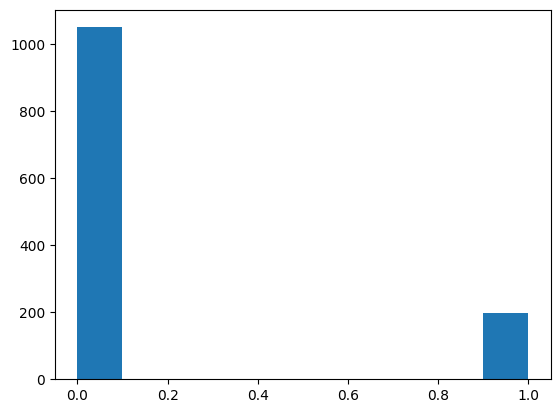

In [57]:
plt.hist(rain_train_b)

In [58]:
rain_train_c = np.array(rain_train_b)
rain_train_c.shape

(1250,)

In [59]:
rain_val = []  


for batch in meteo_val:
    # Convert the entire batch to a NumPy array
    batch_numpy = batch.numpy()

    # Sum the values in the last column
    last_column_sum = tf.reduce_sum(batch_numpy[:, -1])

    # Append the sum to the list
    rain_val.append(last_column_sum.numpy())

In [60]:
rain_val_b = [1 if 0.10 <= r else 0 for r in rain_val]

In [61]:
rain_val_c = np.array(rain_val_b)
rain_val_c.shape

(312,)

In [62]:
cloud_train.shape, rain_train_c.shape, cloud_val.shape, rain_val_c.shape

((1250, 8, 48, 48, 1), (1250,), (312, 8, 48, 48, 1), (312,))

In [64]:
batch_size = 8

train_dataset = tf.data.Dataset.from_tensor_slices((cloud_train, rain_train_c))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((cloud_val, rain_val_c))
val_dataset = val_dataset.batch(batch_size)

In these lines, a TensorFlow data pipeline is established for training and validation datasets. The training dataset is created by slicing the input tensors (cloud_train and rain_train_c), shuffling the data with a buffer size of 10000, and then batching it with the specified batch_size. Similarly, the validation dataset is created by slicing the validation tensors (cloud_val and rain_val_c) and batching it with the same batch_size.

In [65]:
def compute_class_weights_manual(y):
    """
    Compute class weights for imbalanced datasets manually.
    
    Parameters:
    - y: Numpy array or pandas Series containing class labels.
    
    Returns:
    - Dictionary of class weights.
    """
    classes = np.unique(y)
    class_counts = np.bincount(y)
    
    total_samples = len(y)
    class_weights = total_samples / (len(classes) * class_counts)
    
    class_weights_dict = dict(zip(classes, class_weights))
    return class_weights_dict

# Example usage:
class_weights_manual = compute_class_weights_manual(rain_train_c)
print("Manual Class Weights:", class_weights_manual)

Manual Class Weights: {0: 0.5946717411988582, 1: 3.14070351758794}


This code defines a function compute_class_weights_manual that calculates class weights for imbalanced datasets manually. It takes a numpy array or pandas Series containing class labels (y) as input, computes class weights using a formula, and returns a dictionary mapping each class to its corresponding weight.

In [66]:

adam = Adam(learning_rate=0.001)
embed_dim = 8  # Adjust based on your data
num_heads = 4  # Adjust based on your data
ff_dim = 32  # Adjust based on your data
num_transformer_blocks = 2  # Adjust based on your data
mlp_units = [16]  # Adjust based on your data

input_shape = (8, 48, 48, 1)  # Adjust based on your data
output_dim = 1  # Adjust based on your data

dropout = 0.25  # Adjust based on your data
batch_size = 32  # Adjust based on your data

#model = build_transformer_model(embed_dim, num_heads, ff_dim, input_shape, output_dim, num_transformer_blocks, mlp_units, dropout)
input_shape = (8, 48, 48, 1)
output_dim = 1

In this code, hyperparameters and configurations for a transformer model are set, including the learning rate, embedding dimension, number of attention heads, feedforward dimension, number of transformer blocks, dense layer units, input shape, output dimension, dropout rate, and batch size.

### Conv LSTM Model without Attention

This code defines a Sequential model for a ConvLSTM-based neural network. It includes ConvLSTM layers with BatchNormalization and Dropout for regularization. The model is compiled with the Adam optimizer using mean squared error as the loss function.

In [67]:
from keras.layers import Dropout

model = Sequential()

adam = Adam(learning_rate=0.001)

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add dropout with a specified rate (e.g., 0.5)

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add dropout with a specified rate (e.g., 0.5)

# Add Spatial Attention
# model.add(Attention(use_scale=True))

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add dropout with a specified rate (e.g., 0.5)

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add dropout with a specified rate (e.g., 0.5)

model.add(Dense(output_dim, activation='linear'))

model.compile(optimizer=adam, loss='mse', metrics=['mse', 'accuracy'])

model.summary()


2023-12-13 14:01:09.432311: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 8, 48, 48, 32)     38144     
                                                                 
 batch_normalization (Batch  (None, 8, 48, 48, 32)     128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 8, 48, 48, 32)     0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 8, 48, 48, 32)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 8, 48, 48, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8, 48, 48, 32)     0

In [68]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.models import load_model

epochs = 30

earlyStop = EarlyStopping(monitor='val_mse', patience=5, verbose=1, mode='min')

# Define a ramp-up learning rate function
def ramp_up_learning_rate(epoch, initial_lr=1e-4, rampup_length=10):
    start_lr = 1e-3; min_lr = 1e-3; max_lr = 2e-3

    # define the number of epochs to increase 
    # LR lineary and then the decay factor
    rampup_epochs = 6; sustain_epochs = 0; exp_decay = .5

    # method to update the LR value based on the current epoch
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr,
              rampup_epochs, sustain_epochs, exp_decay)

# Define a step decay function
def step_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop
    new_lr = initial_lr * (drop ** (epoch // epochs_drop))
    return new_lr

# Create a LearningRateScheduler
lr_scheduler = LearningRateScheduler(step_decay)
model_save = ModelCheckpoint('modelV1.h5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_scheduler = LearningRateScheduler(step_decay, verbose=1)
lr_scheduler_rampup = LearningRateScheduler(lambda epochs: ramp_up_learning_rate(epochs, rampup_length=10), verbose=1)


In this code, various callback functions for training a Keras model are defined. These include an EarlyStopping callback, a LearningRateScheduler with a step decay function, and a ModelCheckpoint callback to save the best model during training. Additionally, a custom ramp-up learning rate function is defined for a separate LearningRateScheduler. Adjust the parameters based on your specific requirements.

In [69]:
try:
    model = load_model('modelV1.h5')
    print("Model loaded successfully")
except:
    print("No model found")
#model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['mse'])

### we will use exponential decay for the learning rate and have checkpoints for the model

model_save = ModelCheckpoint('modelV1.h5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_scheduler = LearningRateScheduler(step_decay, verbose=1)
lr_scheduler_rampup = LearningRateScheduler(lambda epochs: ramp_up_learning_rate(epochs, rampup_length=5), verbose=1)
### Now we will train the model using the train data and validate it using the validation data
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[learning_rate_scheduler, model_save], class_weight=class_weights_manual)

Model loaded successfully

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30


2023-12-13 13:17:06.878016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-13 13:17:06.987956: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 13:17:09.148249: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f540002abf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 13:17:09.148291: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-13 13:17:09.166319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 13:17:09.299580: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 [==============================] - ETA: 0s - loss: 0.0606 - mse: 0.0654 - accuracy: 0.9472

/home/tarush/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 19s 83ms/step - loss: 0.0606 - mse: 0.0654 - accuracy: 0.9472 - val_loss: 0.0465 - val_mse: 0.0465 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/30
157/157 [==============================] - 12s 78ms/step - loss: 0.0713 - mse: 0.0732 - accuracy: 0.9480 - val_loss: 0.0493 - val_mse: 0.0493 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/30
157/157 [==============================] - 12s 79ms/step - loss: 0.0619 - mse: 0.0710 - accuracy: 0.9456 - val_loss: 0.2489 - val_mse: 0.2491 - val_accuracy: 0.9968 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/30
157/157 [==============================] - 12s 78ms/step - loss: 0.0724 - mse: 0.0798 - accuracy: 0.9352 - val_loss: 0.0656 - val_mse: 0.0656 - val_accuracy: 0.9679 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.

In this code, a pre-existing model is attempted to be loaded from 'modelV1.h5'. If the model is not found, a new model should be created. 

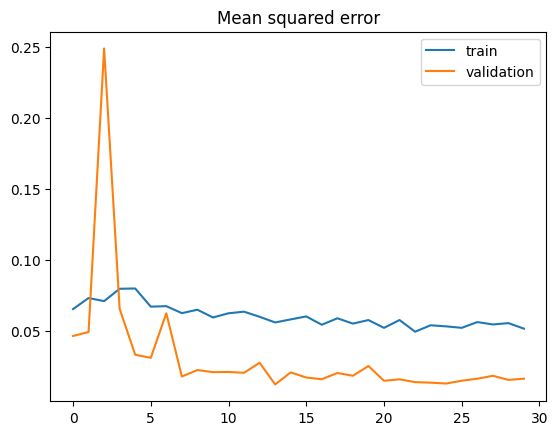

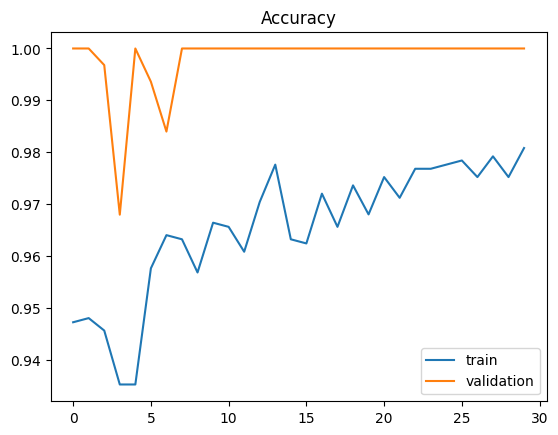

In [70]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.legend(['train', 'validation'])
plt.title('Mean squared error')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('Accuracy')
plt.show()


The first graph illustrates the mean squared error for both the training and validation datasets over epochs. The second graph shows the accuracy for the training and validation datasets over the same epochs.

In [71]:
y_pred = model.predict(cloud_val)

y_pred_b = [1 if 0.10 <= r else 0 for r in y_pred]

y_pred_c = np.array(y_pred_b)

f1_score(rain_val_c, y_pred_c)

### we will also get f1 scores for different classes of rain
print(classification_report(rain_val_c, y_pred_c))


10/10 [==============================] - 1s 60ms/step
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       263
           1       0.30      1.00      0.47        49

    accuracy                           0.64       312
   macro avg       0.65      0.79      0.60       312
weighted avg       0.89      0.64      0.69       312



The classification report provides insights into the performance of the trained model on the validation dataset:

Class 0 (No Rain):<br>
Precision: 1.00 (All instances predicted as no rain are correct)<br>
Recall: 0.57 (57% of actual no rain instances are correctly predicted)<br>
F1-score: 0.73

Class 1 (Rain):<br>
Precision: 0.30 (Only 30% of instances predicted as rain are correct)<br>
Recall: 1.00 (All actual rain instances are correctly predicted)<br>
F1-score: 0.47<br>

Overall Performance:<br>
Accuracy: 0.64 (64% of predictions are correct)<br>
Macro Avg F1-score: 0.60 (Unweighted average of F1-scores for each class)<br>
Weighted Avg F1-score: 0.69 (Weighted average of F1-scores considering class imbalance)

### Make Predictions

The predict_rain function takes a sequence as input, makes predictions using the trained model, and filters sequences and their corresponding rain predictions based on a probability threshold (0.5).

In [72]:
### we will write a function that takes a sequence for a day and predicts the rain for the next 2-3 days
def predict_rain(sequence):
    # Make a prediction on the sequence
    preds = model.predict(sequence)
    # Get just the probabilities for the positive class
    positive_prob = preds[:, 0]  
    # Get a mask for filtering out only the positive class probabilities
    rain_mask = positive_prob > 0.5
    # Filter the probabilities with the mask
    rain_preds = positive_prob[rain_mask]
    # Get the indices to keep for rain predictions
    rain_index = np.where(rain_mask)[0]
    # Get the actual sequences
    sequences = sequence[rain_index]
    # Return the sequences and their rain predictions
    return sequences, rain_preds

# Get the sequences and rain probabilities for the validation set
val_sequences, rain_preds = predict_rain(cloud_val)

# Print the shape of each array
print("Sequences shape:", val_sequences.shape)
print("Rain preds shape:", rain_preds.shape)

# Get the mean of the predicted rain probabilities
prob_true = np.mean(rain_preds)
print("Probability of rain: {:.2f}%".format(prob_true * 100))

# Get the actual sequences corresponding to rain predictions
sequences, _ = predict_rain(cloud_val)

# Select the first sequence
sequence = sequences[0]

# Get the rain prediction
prediction = model.predict(sequence[np.newaxis, ...])
prediction = prediction[0, 0]  # Changed this line

# Get the corresponding label
label = "Positive" if prediction > 0.5 else "Negative"

# Print the results
print("Rain prediction:", prediction)
print("Label:", label)


10/10 [==============================] - 0s 51ms/step
Sequences shape: (49, 8, 48, 48, 1)
Rain preds shape: (49,)
Probability of rain: 110.64%
1/1 [==============================] - 0s 124ms/step
Rain prediction: 1.042
Label: Positive


Not bad but we will try once with a model that uses attention and see if the model is able to learn better

### Improved model: ConvLSTM with attention

In [75]:
try:
    model = load_model('modelV3Attention.h5')
    print("Model loaded successfully")
except:
    print("No model found")

model_save = ModelCheckpoint('modelV3Attention.h5', save_best_only=True, monitor='val_loss', mode='min')

# Assuming input_shape is (time_steps, height, width, channels)
input_shape = (8, 48, 48, 1)
output_dim = 1

# Define the input layer
inputs = Input(shape=input_shape)

# ConvLSTM layer 1
x = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
x = BatchNormalization()(x)

# ConvLSTM layer 2
x = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
x = BatchNormalization()(x)

# Attention mechanism
attn = Attention(use_scale=True)([x, x])

# Apply attention to the output of ConvLSTM layer 2
attended_x = tf.multiply(x, attn)

# Additional ConvLSTM layer
x = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(attended_x)
x = BatchNormalization()(x)

# Flatten the output before applying dense layers
x = Flatten()(x)

# Dense layers
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Output layer
outputs = Dense(output_dim, activation='linear')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'accuracy'])

# Display the model summary
model.summary()        

No model found
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 8, 48, 48, 1)]       0         []                            
                                                                                                  
 conv_lstm2d_12 (ConvLSTM2D  (None, 8, 48, 48, 16)        9856      ['input_4[0][0]']             
 )                                                                                                
                                                                                                  
 batch_normalization_16 (Ba  (None, 8, 48, 48, 16)        64        ['conv_lstm2d_12[0][0]']      
 tchNormalization)                                                                                
                                                                             

In [76]:
history = model.fit(cloud_train, rain_train_c, epochs=80, validation_data=(cloud_val, rain_val_c), callbacks=[lr_scheduler_rampup, model_save], class_weight=class_weights_manual)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/80
40/40 [==============================] - ETA: 0s - loss: 1.9217 - mse: 1.8764 - accuracy: 0.6240

/home/tarush/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 11s 152ms/step - loss: 1.9217 - mse: 1.8764 - accuracy: 0.6240 - val_loss: 0.6220 - val_mse: 0.6221 - val_accuracy: 0.1571 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0011666666666666668.
Epoch 2/80
40/40 [==============================] - 5s 125ms/step - loss: 0.8583 - mse: 0.8197 - accuracy: 0.5616 - val_loss: 0.6942 - val_mse: 0.6941 - val_accuracy: 0.1571 - lr: 0.0012

Epoch 3: LearningRateScheduler setting learning rate to 0.0013333333333333333.
Epoch 3/80
40/40 [==============================] - 5s 125ms/step - loss: 0.6371 - mse: 0.6682 - accuracy: 0.5800 - val_loss: 1.5539 - val_mse: 1.5539 - val_accuracy: 0.1571 - lr: 0.0013

Epoch 4: LearningRateScheduler setting learning rate to 0.0015.
Epoch 4/80
40/40 [==============================] - 5s 125ms/step - loss: 0.6073 - mse: 0.6600 - accuracy: 0.5496 - val_loss: 1.3055 - val_mse: 1.3054 - val_accuracy: 0.1571 - lr: 0.0015

Epoch 5: LearningRateScheduler setti

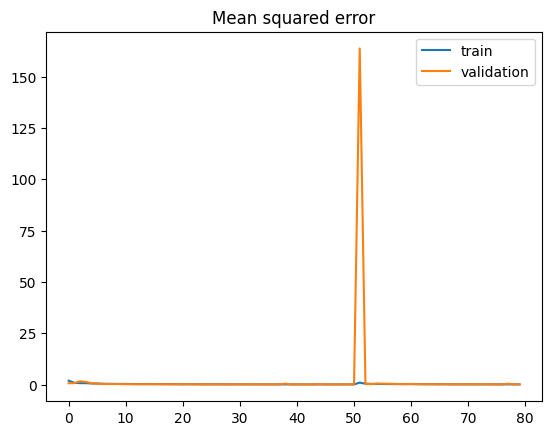

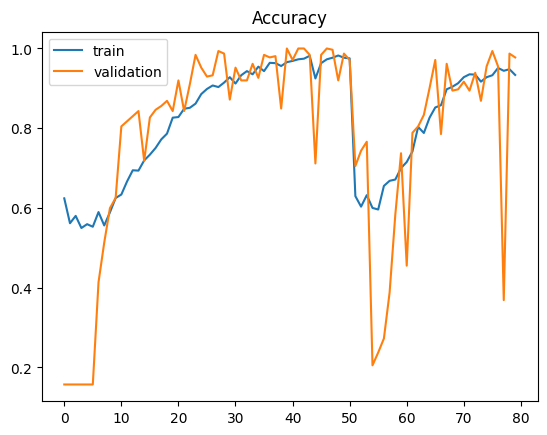

10/10 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       263
           1       0.72      1.00      0.84        49

    accuracy                           0.94       312
   macro avg       0.86      0.96      0.90       312
weighted avg       0.96      0.94      0.94       312



In [77]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.legend(['train', 'validation'])
plt.title('Mean squared error')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('Accuracy')
plt.show()


### we also compute the f1 score for the validation data

y_pred = model.predict(cloud_val)

y_pred_b = [1 if 0.10 <= r else 0 for r in y_pred]

y_pred_c = np.array(y_pred_b)

f1_score(rain_val_c, y_pred_c)

### we will also get f1 scores for different classes of rain


print(classification_report(rain_val_c, y_pred_c))

### Conclusion:

We tested out different models to make predictions and Conv LSTM with attention gave us the best results.

Thank you